In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import spacy

ModuleNotFoundError: No module named 'matplotlib'

In [6]:
from nltk.corpus import stopwords
ru_stopwords = set(stopwords.words("russian"))
en_stopwords = set(stopwords.words("english"))

ru_stopwords.add('это')
ru_stopwords.add('всё')
ru_stopwords.add('свой')
ru_stopwords.add('ещё')
ru_stopwords.add('весь')

en_stopwords.add("'s")

from string import punctuation
punct_list = [c for c in punctuation]
punct_list.append('--')
punct_list.append('...')
punct_list.append('–')

In [7]:
from easynmt import EasyNMT
model = EasyNMT('opus-mt')

In [8]:
sentence = "I hate"
model.translate(sentence, target_lang='ru', beam_size=1)

/home/warri/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'Ненавижу'

In [37]:
def plot_variety_pie(variety_dict, other_len: int, original_word: str):
    variety_dict_items = list(variety_dict.items())
    variety_dict_items.sort(key=lambda x: -len(x[1]))
    translations = [x[0] for x in variety_dict_items]
    # translations.append("other")
    number_of_matches = [len(x[1]) for x in variety_dict_items]
    # number_of_matches.append(other_len)

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    plt.pie(number_of_matches, autopct = lambda pct: func(pct, number_of_matches), labels = translations)

    plt.title(original_word)
    plt.legend(bbox_to_anchor=(0.85,1.025), loc="upper left")

    # show plot
    plt.show()

In [10]:
from simalign import SentenceAligner
from tqdm import tqdm
import spacy

In [11]:
myaligner = SentenceAligner(model="bert", token_type="bpe", matching_methods="mai")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2023-04-05 17:42:24,085 - simalign.simalign - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased


In [12]:
en_nlp_sm = spacy.load("en_core_web_sm")
ru_nlp_sm = spacy.load("ru_core_news_sm")

In [13]:
with open("./corpora/karenina/en_lemmas.txt", "rt", encoding="utf-8") as file:
    en_lemmas = [[word for word in line.rstrip().split()] for line in file]

with open("./corpora/karenina/ru_lemmas.txt", "rt", encoding="utf-8") as file:
    ru_lemmas = [[word for word in line.rstrip().split()] for line in file]

In [14]:
with open("./corpora/karenina/en_tokens.txt", "rt", encoding="utf-8") as file:
    en_tokens = [line.rstrip().split() for line in file]

with open("./corpora/karenina/ru_tokens.txt", "rt", encoding="utf-8") as file:
    ru_tokens = [line.rstrip().split() for line in file]

In [15]:
with open("./corpora/karenina/originals/Books_en.txt", "rt", encoding="utf-8") as file:
    en_corpus_raw = [line.rstrip() for line in file]

with open("./corpora/karenina/originals/Books_ru.txt", "rt", encoding="utf-8") as file:
    ru_corpus_raw = [line.rstrip() for line in file]

In [16]:
with open("./corpora/karenina/numerical_alignment/inter.txt", "rt", encoding="utf-8") as file:
    aligned_inter = [[tuple(map(int, pair.split('-'))) for pair in line.rstrip().split()] for line in file]

with open("./corpora/karenina/numerical_alignment/itermax.txt", "rt", encoding="utf-8") as file:
    aligned_itermax = [[tuple(map(int, pair.split('-'))) for pair in line.rstrip().split()] for line in file]

with open("./corpora/karenina/numerical_alignment/mwmf.txt", "rt", encoding="utf-8") as file:
    aligned_mwmf = [[tuple(map(int, pair.split('-'))) for pair in line.rstrip().split()] for line in file]

In [33]:
def get_variety_dict_from_alignment(original_word: str, aligned_text: list, orig_lemmas: list, foreign_lemmas: list):
    variety_dict = defaultdict(lambda : [])
    translation_dict = defaultdict(lambda : [])
    align_data = []
    for i, num_sentence_pairs in tqdm(enumerate(aligned_text)):
        # small_dict = defaultdict(lambda : 0)
        # phrase = []
        for src_idx, tgt_idx in num_sentence_pairs:
            try:
                if orig_lemmas[i][src_idx] == original_word and \
                    foreign_lemmas[i][tgt_idx] not in ru_stopwords \
                        and foreign_lemmas[i][tgt_idx] not in en_stopwords \
                            and foreign_lemmas[i][tgt_idx] not in punct_list:
                    variety_dict[foreign_lemmas[i][tgt_idx]].append(i)

                    translation = model.translate(ru_corpus_raw[i], target_lang='en', beam_size=10, max_new_tokens=512)
                    translation_doc = en_nlp_sm(translation)
                    translation_tokens = [word.text for word in translation_doc]
                    translation_lemmas = [word.lemma_ for word in translation_doc]
                    alignments = myaligner.get_word_aligns(ru_tokens[i], translation_tokens)
                    align_data.append((i, translation_doc, alignments))

                    for x, y in alignments["inter"]:
                        if orig_lemmas[i][x] == original_word and \
                            translation_lemmas[y] not in ru_stopwords \
                                and translation_lemmas[y] not in en_stopwords \
                                    and translation_lemmas[y] not in punct_list:
                            translation_dict[translation_lemmas[y]].append(i)
            except:
                print(i, src_idx, tgt_idx)
                continue

        # if phrase:
        #     phrase.sort()
        #     small_dict[' '.join(phrase)] += 1

        # for phrase, cnt in small_dict.items():
        #     variety_dict[phrase] += cnt

    return variety_dict, translation_dict, align_data

In [56]:
word = "интересный"
data = get_variety_dict_from_alignment(word, aligned_inter, ru_lemmas, en_lemmas)

5616it [00:22, 168.32it/s]

5996 195 202


17255it [01:35, 180.04it/s]


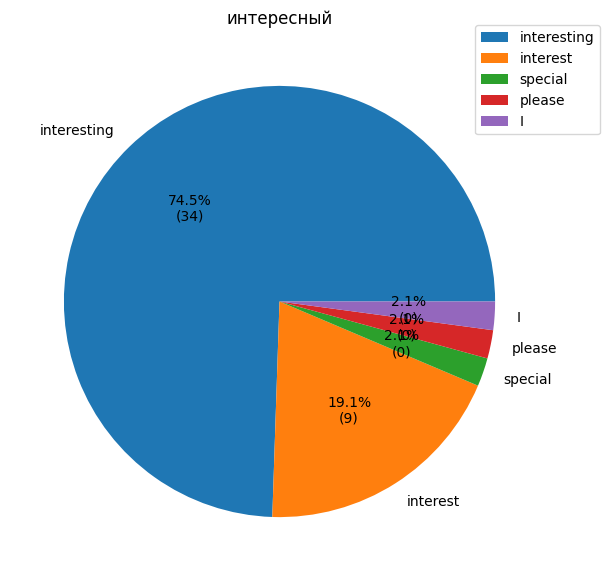

In [57]:
plot_variety_pie(data[0], 0, word)

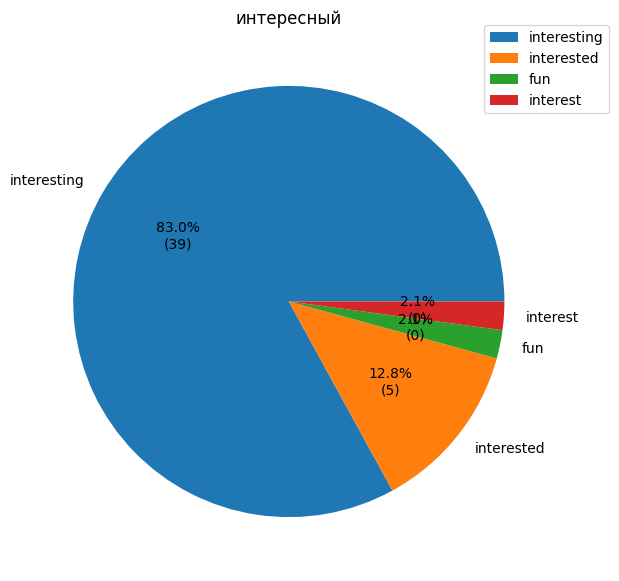

In [58]:
plot_variety_pie(data[1], 0, word)

In [21]:
data[2]

[(35,
  She hasn't wanted to see her husband since.,
  {'mwmf': [(0, 8),
    (1, 2),
    (2, 1),
    (3, 0),
    (4, 2),
    (5, 3),
    (5, 4),
    (6, 5),
    (6, 6),
    (7, 7),
    (8, 9)],
   'inter': [(2, 8), (3, 0), (4, 2), (5, 3), (6, 5), (7, 7), (8, 9)],
   'itermax': [(2, 8),
    (3, 0),
    (4, 2),
    (5, 3),
    (6, 4),
    (6, 5),
    (7, 7),
    (8, 9)]}),
 (221,
  She saw him as sorry for herself, but not love.,
  {'mwmf': [(0, 0),
    (1, 1),
    (1, 3),
    (3, 2),
    (4, 5),
    (5, 6),
    (6, 4),
    (7, 7),
    (8, 8),
    (9, 9),
    (10, 10),
    (11, 11)],
   'inter': [(0, 0),
    (1, 1),
    (3, 2),
    (4, 5),
    (5, 6),
    (6, 4),
    (7, 7),
    (8, 8),
    (9, 9),
    (10, 10),
    (11, 11)],
   'itermax': [(0, 0),
    (1, 1),
    (3, 2),
    (4, 5),
    (5, 6),
    (6, 4),
    (7, 7),
    (8, 8),
    (9, 9),
    (10, 10),
    (11, 11)]}),
 (234,
  I don't even see an opportunity.,
  {'mwmf': [(0, 0), (1, 2), (2, 1), (2, 4), (3, 3), (4, 6), (5, 7)],
   

In [22]:
translation_data = ["" for i in range(len(ru_corpus_raw))]
aligned_data_itermax = ["" for i in range(len(ru_corpus_raw))]
aligned_data_inter = ["" for i in range(len(ru_corpus_raw))]
aligned_data_mwmf = ["" for i in range(len(ru_corpus_raw))]
for idx, translation, alignments in data[2]:
    translation_data[idx] = translation
    aligned_data_mwmf[idx] = " ".join([f"{x}-{y}" for x, y in alignments["mwmf"]])
    aligned_data_itermax[idx] = " ".join([f"{x}-{y}" for x, y in alignments["itermax"]])
    aligned_data_inter[idx] = " ".join([f"{x}-{y}" for x, y in alignments["inter"]])

In [61]:
from spacy.tokens import DocBin

In [74]:
data[2][0][0]

1308

In [75]:
with open("./corpora/karenina/translations/ru-en_opus_beam10/ru-en_translated_spacy_docs.bin", "rb+") as file:
    doc_bin = DocBin().from_bytes(file.read())
    nlp = spacy.blank("en")
    docs = list(doc_bin.get_docs(nlp.vocab))
    empty_doc = en_nlp_sm("")
    data_ptr = 0
    new_doc_bin = DocBin()
    for i in range(len(ru_corpus_raw)):
        if i == data[2][data_ptr][0]:
            new_doc_bin.add(data[2][data_ptr][1])
            data_ptr += 1
            if data_ptr > len(data[2]):
                break
    bytes_data = doc_bin.to_bytes()
    file.write(bytes_data)

TypeError: 'DocBin' object does not support item assignment

In [72]:
# Deserialize later, e.g. in a new process
nlp = spacy.blank("en")
doc_bin = DocBin().from_bytes(bytes_data)
docs = list(doc_bin.get_docs(nlp.vocab))

In [55]:
ru_corpus_raw

['Анна Каренина',
 'Толстой Лев Николаевич',
 'Мне отмщение, и аз воздам',
 'ЧАСТЬ ПЕРВАЯ',
 'Все счастливые семьи похожи друг на друга, каждая несчастливая семья несчастлива по-своему.',
 'Все смешалось в доме Облонских.',
 'Жена узнала, что муж был в связи с бывшею в их доме француженкою-гувернанткой, и объявила мужу, что не может жить с ним в одном доме.',
 'Положение это продолжалось уже третий день и мучительно чувствовалось и самими супругами, и всеми членами семьи, и домочадцами.',
 'Все члены семьи и домочадцы чувствовали, что нет смысла в их сожительстве и что на каждом постоялом дворе случайно сошедшиеся люди более связаны между собой, чем они, члены семьи и домочадцы Облонских.',
 'Жена не выходила из своих комнат, мужа третий день не было дома. Дети бегали по всему дому, как потерянные; англичанка поссорилась с экономкой и написала записку приятельнице, прося приискать ей новое место; повар ушел еще вчера со двора, во время обеда; черная кухарка и кучер просили расчета.',
 

In [54]:
docs

[,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 He even felt that she, a exhausted, old, ugly woman and nothing wonderful, simple, but a kind mother of the family, should be pardoned in the sense of justice.,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 

In [65]:
data[2][0]

(1308,
 She's very interesting.,
 {'mwmf': [(0, 0), (1, 2), (2, 1), (2, 3), (3, 4)],
  'inter': [(0, 0), (1, 2), (2, 3), (3, 4)],
  'itermax': [(0, 0), (1, 2), (2, 1), (2, 3), (3, 4)]})

In [73]:
docs[1308]

In [24]:
with open("./corpora/karenina/translations/ru-en_opus_beam5/text.txt", "r+") as file:
    text = file.readlines()
    if len(text) == 0:
        text = ["" for _ in range(len(ru_corpus_raw))]
    for idx, translation, alignments in data[2]:
        text[idx] = translation
    file.write('\n'.join(text))

TypeError: sequence item 35: expected str instance, spacy.tokens.doc.Doc found